<a href="https://colab.research.google.com/github/sympalee/kmms/blob/main/10%EC%B0%A8_%EC%8B%9C%EC%9E%A5_%ED%85%8C%EC%9D%BC_%EB%A6%AC%EC%8A%A4%ED%81%AC%EC%9D%98_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EA%B8%B0%EB%B0%98_%EC%99%9C%EB%8F%84%EC%A7%80%EC%88%98_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8_%EC%97%B0%EA%B5%AC_LSTM%2C_Transformer%2C_TCN%2C_N_HiTS_%EB%B9%84%EA%B5%90_20240609.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tcn==3.4.0
!pip install torch
!pip install torchinfo
!pip install tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Conv1D, MaxPooling1D, Flatten, RepeatVector, Bidirectional, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Rescaling
from tcn import TCN, tcn_full_summary # TCN for Keras

# Scikit-learn for data preprocessing and metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

# ACF
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

        Date    SKEW      S&P500    VIX
0 1990-01-02  126.09  359.690002  17.24
1 1990-01-03  123.34  358.760010  18.19
2 1990-01-04  122.62  355.670013  19.22
3 1990-01-05  121.27  352.200012  20.11
4 1990-01-08  124.12  353.790009  20.26
               mean          std         min         50%          max  \
SKEW     121.484902     9.807847  101.230000   119.22000   170.550000   
S&P500  1608.341492  1123.578479  295.459991  1271.48999  5254.350098   
VIX       19.543096     7.902848    9.140000    17.69500    82.690000   

            skew      kurt  
SKEW    1.199680  1.448064  
S&P500  1.260279  0.830269  
VIX     2.162533  8.358134  
             n     Mean       Sd     Min   Median      Max  Skewness  Kurtosis
SKEW    8606.0   121.48     9.81  101.23   119.22   170.55      1.20      1.45
S&P500  8606.0  1608.34  1123.58  295.46  1271.49  5254.35      1.26      0.83
VIX     8606.0    19.54     7.90    9.14    17.70    82.69      2.16      8.36


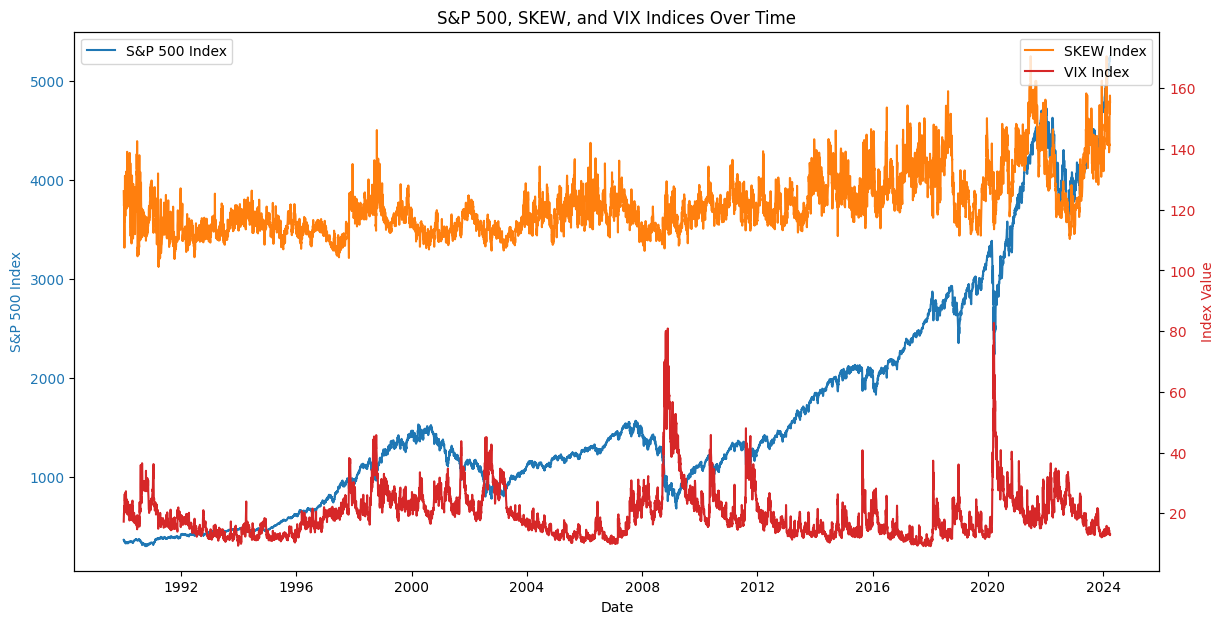

In [ ]:
# 데이터 로드
skew_data = pd.read_csv('/content/SKEW_History.csv')
sp500_data = pd.read_csv('/content/S&P500_History.csv')
vix_data = pd.read_csv('/content/VIX_History.csv')

# 날짜 변환
skew_data['Date'] = pd.to_datetime(skew_data['Date'])
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
vix_data['Date'] = pd.to_datetime(vix_data['Date'])

# 데이터 병합
merged_data = pd.merge(pd.merge(skew_data, sp500_data, on='Date'), vix_data, on='Date')

# 병합된 데이터 출력
print(merged_data.head())

# 병합된 데이터를 CSV 파일로 저장
merged_data.to_csv('merged_data.csv', index=False)

# 기초 통계 생성
numeric_data = merged_data.select_dtypes(include=['float64', 'int64'])  # 숫자형 데이터만 선택
stats = numeric_data.describe().transpose()
stats['skew'] = numeric_data.skew()  # 왜도 추가
stats['kurt'] = numeric_data.kurtosis()  # 첨도 추가

# 통계를 출력할 때 필요한 칼럼들 선택
print(stats[['mean', 'std', 'min', '50%', 'max', 'skew', 'kurt']])

# 병합된 데이터에서 숫자형 데이터만 선택
numeric_data = merged_data.select_dtypes(include=['float64', 'int64'])

# 기초 통계 및 왜도, 첨도 계산
stats = numeric_data.describe().transpose()
stats['skew'] = numeric_data.skew()
stats['kurt'] = numeric_data.kurtosis()

# 필요한 컬럼만 선택하여 새로운 DataFrame 생성
final_stats = pd.DataFrame({
    'n': stats['count'],
    'Mean': stats['mean'],
    'Sd': stats['std'],
    'Min': stats['min'],
    'Median': stats['50%'],
    'Max': stats['max'],
    'Skewness': stats['skew'],
    'Kurtosis': stats['kurt']
})

# DataFrame을 보기 좋게 정리
final_stats = final_stats.round(2)  # 소수점 두 자리로 반올림
print(final_stats)

# 그래프 생성
fig, ax1 = plt.subplots(figsize=(14, 7))

# 첫 번째 y축 설정 (S&P 500)
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500 Index', color='tab:blue')
ax1.plot(merged_data['Date'], merged_data['S&P500'], color='tab:blue', label='S&P 500 Index')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# 두 번째 y축 설정 (SKEW와 VIX)
ax2 = ax1.twinx()  # x축을 공유하는 두 번째 y축 생성
ax2.set_ylabel('Index Value', color='tab:red')  # 두 번째 y축 레이블 설정
ax2.plot(merged_data['Date'], merged_data['SKEW'], color='tab:orange', label='SKEW Index', linestyle='-')
ax2.plot(merged_data['Date'], merged_data['VIX'], color='tab:red', label='VIX Index', linestyle='-')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('S&P 500, SKEW, and VIX Indices Over Time')
plt.show()

# 데이터 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(merged_data.drop('Date', axis=1))

# 데이터셋 생성 함수
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :-1]
        dataX.append(a)
        dataY.append(dataset[i + time_step, -1])
    return np.array(dataX), np.array(dataY)

# 데이터셋 준비
time_step = 22
X, y = create_dataset(data_scaled, time_step)

# 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

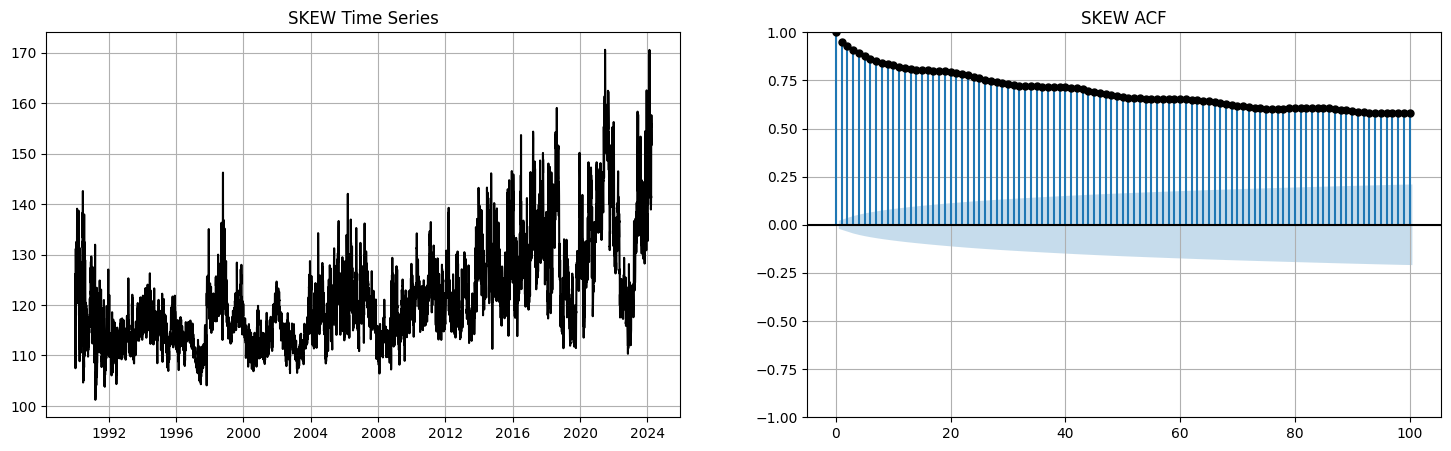

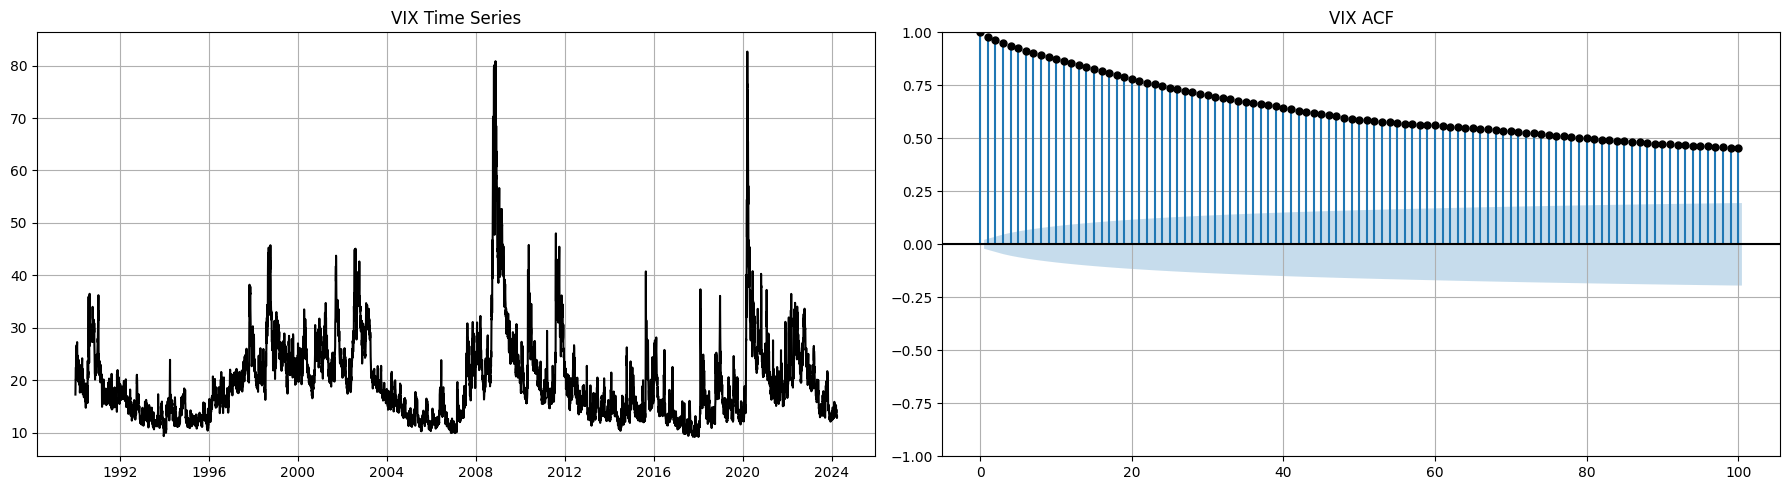

In [ ]:
# skew 데이터 로드
skew_data = pd.read_csv('SKEW_History.csv', index_col='Date', parse_dates=True)

# SKEW 시계열 및 ACF 그래프 - 좌우 배치
fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 여기서 1행 2열로 변경

# 좌측 그래프 - SKEW 시계열 데이터
axes[0].plot(skew_data['SKEW'], color='black')  # 'SKEW'는 실제 SKEW 데이터셋의 컬럼 이름으로 가정
axes[0].set_title('SKEW Time Series')
axes[0].grid(True)

# 우측 그래프 - SKEW ACF
plot_acf(skew_data['SKEW'], lags=100, ax=axes[1], alpha=0.05, color='black')
axes[1].set_title('SKEW ACF')
axes[1].grid(True)

# vix 데이터 로드
vix_data = pd.read_csv('VIX_History.csv', index_col='Date', parse_dates=True)

# SKEW 시계열 및 ACF 그래프 - 좌우 배치
fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 여기서 1행 2열로 변경

# 좌측 그래프 - SKEW 시계열 데이터
axes[0].plot(vix_data['VIX'], color='black')  # 'SKEW'는 실제 SKEW 데이터셋의 컬럼 이름으로 가정
axes[0].set_title('VIX Time Series')
axes[0].grid(True)

# 우측 그래프 - SKEW ACF
plot_acf(vix_data['VIX'], lags=100, ax=axes[1], alpha=0.05, color='black')
axes[1].set_title('VIX ACF')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# LSTM 모델
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
optimizer_lstm = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer_lstm, loss='mean_squared_error')

# LSTM 모델 훈련
lstm_history = model_lstm.fit(X_train, y_train, epochs=300, batch_size=32, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# LSTM 예측
train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)

# 결과 출력 (옵션)
print("Training predictions:", train_predict_lstm[:5])
print("Testing predictions:", test_predict_lstm[:5])

Epoch 1/300
172/172 [==============================] - 22s 81ms/step - loss: 0.0120 - val_loss: 0.0122
Epoch 2/300
172/172 [==============================] - 10s 60ms/step - loss: 0.0111 - val_loss: 0.0121
Epoch 3/300
172/172 [==============================] - 6s 33ms/step - loss: 0.0109 - val_loss: 0.0122
Epoch 4/300
172/172 [==============================] - 4s 25ms/step - loss: 0.0110 - val_loss: 0.0121
Epoch 5/300
172/172 [==============================] - 4s 25ms/step - loss: 0.0109 - val_loss: 0.0122
Epoch 6/300
172/172 [==============================] - 6s 33ms/step - loss: 0.0109 - val_loss: 0.0122
Epoch 7/300
172/172 [==============================] - 4s 24ms/step - loss: 0.0108 - val_loss: 0.0122
Epoch 8/300
172/172 [==============================] - 4s 25ms/step - loss: 0.0108 - val_loss: 0.0122
Epoch 9/300
172/172 [==============================] - 6s 35ms/step - loss: 0.0108 - val_loss: 0.0121
Epoch 10/300
172/172 [==============================] - 4s 25ms/step - loss: 0.0

In [ ]:
# Transformer 블록을 만드는 함수
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# 전체 Transformer 모델 구성
def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return tf.keras.Model(inputs, outputs)

# 모델 생성 및 컴파일
transformer_model = build_transformer_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.25,
    mlp_dropout=0.25
)
optimizer_transformer = Adam(learning_rate=0.001)
transformer_model.compile(loss='mean_squared_error', optimizer=optimizer_transformer)

# 훈련
transformer_history = transformer_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stopping]
)

# 트랜스포머 예측
train_predict_transformer = transformer_model.predict(X_train)
test_predict_transformer = transformer_model.predict(X_test)

# 결과 출력 (옵션)
print("Training predictions:", train_predict_transformer[:5])
print("Testing predictions:", test_predict_transformer[:5])

Epoch 1/300
172/172 [==============================] - 58s 240ms/step - loss: 0.0551 - val_loss: 0.0210
Epoch 2/300
172/172 [==============================] - 36s 207ms/step - loss: 0.0179 - val_loss: 0.0145
Epoch 3/300
172/172 [==============================] - 39s 226ms/step - loss: 0.0131 - val_loss: 0.0146
Epoch 4/300
172/172 [==============================] - 44s 254ms/step - loss: 0.0122 - val_loss: 0.0143
Epoch 5/300
172/172 [==============================] - 36s 208ms/step - loss: 0.0118 - val_loss: 0.0131
Epoch 6/300
172/172 [==============================] - 40s 230ms/step - loss: 0.0116 - val_loss: 0.0132
Epoch 7/300
172/172 [==============================] - 36s 208ms/step - loss: 0.0115 - val_loss: 0.0128
Epoch 8/300
172/172 [==============================] - 37s 213ms/step - loss: 0.0113 - val_loss: 0.0130
Epoch 9/300
172/172 [==============================] - 40s 235ms/step - loss: 0.0114 - val_loss: 0.0129
Epoch 10/300
172/172 [==============================] - 36s 212m

In [ ]:
def build_tcn_model(input_shape):
    input_layer = Input(shape=input_shape)
    # TCN layer with detailed configurations
    x = TCN(nb_filters=64, kernel_size=6, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32],
            padding='causal', use_skip_connections=True, dropout_rate=0.0,
            return_sequences=False, activation='relu', kernel_initializer='he_normal',
            use_batch_norm=False)(input_layer)
    # Output layer
    output_layer = Dense(1)(x)
    # Building the model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Assuming X_train and y_train are already defined and preprocessed
input_shape = (X_train.shape[1], X_train.shape[2])

# Create the TCN model
tcn_model = build_tcn_model(input_shape)

# Compile the model with Adam optimizer and mean squared error loss
tcn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Training the model
tcn_history = tcn_model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=1,
                            validation_split=0.2, callbacks=[early_stopping])

# Predictions
train_predict_tcn = tcn_model.predict(X_train)
test_predict_tcn = tcn_model.predict(X_test)

# Displaying the model architecture
tcn_model.summary()

# 결과 출력 (옵션)
print("Training predictions:", train_predict_tcn[:5])
print("Testing predictions:", test_predict_tcn[:5])

Epoch 1/300
172/172 [==============================] - 19s 85ms/step - loss: 0.2841 - val_loss: 0.0125
Epoch 2/300
172/172 [==============================] - 14s 80ms/step - loss: 0.0113 - val_loss: 0.0178
Epoch 3/300
172/172 [==============================] - 14s 79ms/step - loss: 0.0101 - val_loss: 0.0121
Epoch 4/300
172/172 [==============================] - 15s 87ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/300
172/172 [==============================] - 16s 94ms/step - loss: 0.0097 - val_loss: 0.0089
Epoch 6/300
172/172 [==============================] - 15s 84ms/step - loss: 0.0091 - val_loss: 0.0082
Epoch 7/300
172/172 [==============================] - 14s 81ms/step - loss: 0.0076 - val_loss: 0.0114
Epoch 8/300
172/172 [==============================] - 16s 92ms/step - loss: 0.0076 - val_loss: 0.0093
Epoch 9/300
172/172 [==============================] - 14s 84ms/step - loss: 0.0072 - val_loss: 0.0068
Epoch 10/300
172/172 [==============================] - 14s 82ms/step - l

In [ ]:
# 모델 정의
class NHiTS(nn.Module):
    def __init__(self, input_size, num_layers, hidden_dim, num_outputs):
        super(NHiTS, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_outputs)

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        lstm_out = lstm_out[:, -1, :]  # only use the last output from sequence
        return self.linear(lstm_out)

# 모델, 데이터 로더 및 최적화 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_hits_model = NHiTS(input_size=X_train.shape[2], num_layers=2, hidden_dim=50, num_outputs=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(n_hits_model.parameters(), lr=0.001)
train_dataset = TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)).view(-1, 1))
test_dataset = TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)).view(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 조기 종료를 위한 기능 구현
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# 훈련 및 검증 과정
def train(model, train_loader, test_loader, optimizer, criterion, early_stopping, num_epochs=300):
    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        training_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_loss /= len(test_loader)
        validation_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return training_losses, validation_losses  # 손실 리스트 반환


# 예측 함수
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
    return np.array(predictions)

# 모델 훈련 및 평가
early_stopping = EarlyStopping(patience=10, verbose=True)
training_losses = train(n_hits_model, train_loader, test_loader, optimizer, criterion, early_stopping)
train_predict_nhits = predict(n_hits_model, train_loader)
test_predict_nhits = predict(n_hits_model, test_loader)

# 결과 출력 (옵션)
print("Training predictions:", train_predict_nhits[:5])
print("Testing predictions:", test_predict_nhits[:5])

Epoch 1/300, Training Loss: 0.012048916349750619, Validation Loss: 0.01147706402224247
Epoch 2/300, Training Loss: 0.011229837914322352, Validation Loss: 0.011497919374421515
Epoch 3/300, Training Loss: 0.011148790482345015, Validation Loss: 0.011262254185836625
Epoch 4/300, Training Loss: 0.011105103509197401, Validation Loss: 0.011221588559069292
Epoch 5/300, Training Loss: 0.011099081607752068, Validation Loss: 0.011297963059472817
Epoch 6/300, Training Loss: 0.011141788941093309, Validation Loss: 0.011224380836615132
Epoch 7/300, Training Loss: 0.011086557265154498, Validation Loss: 0.011261199131021622
Epoch 8/300, Training Loss: 0.011058444997598959, Validation Loss: 0.011309832623400897
Epoch 9/300, Training Loss: 0.011085384995351697, Validation Loss: 0.011546972621646192
Epoch 10/300, Training Loss: 0.011023902791270683, Validation Loss: 0.011215788131165836
Epoch 11/300, Training Loss: 0.010989142079339471, Validation Loss: 0.011362149776821887
Epoch 12/300, Training Loss: 0.

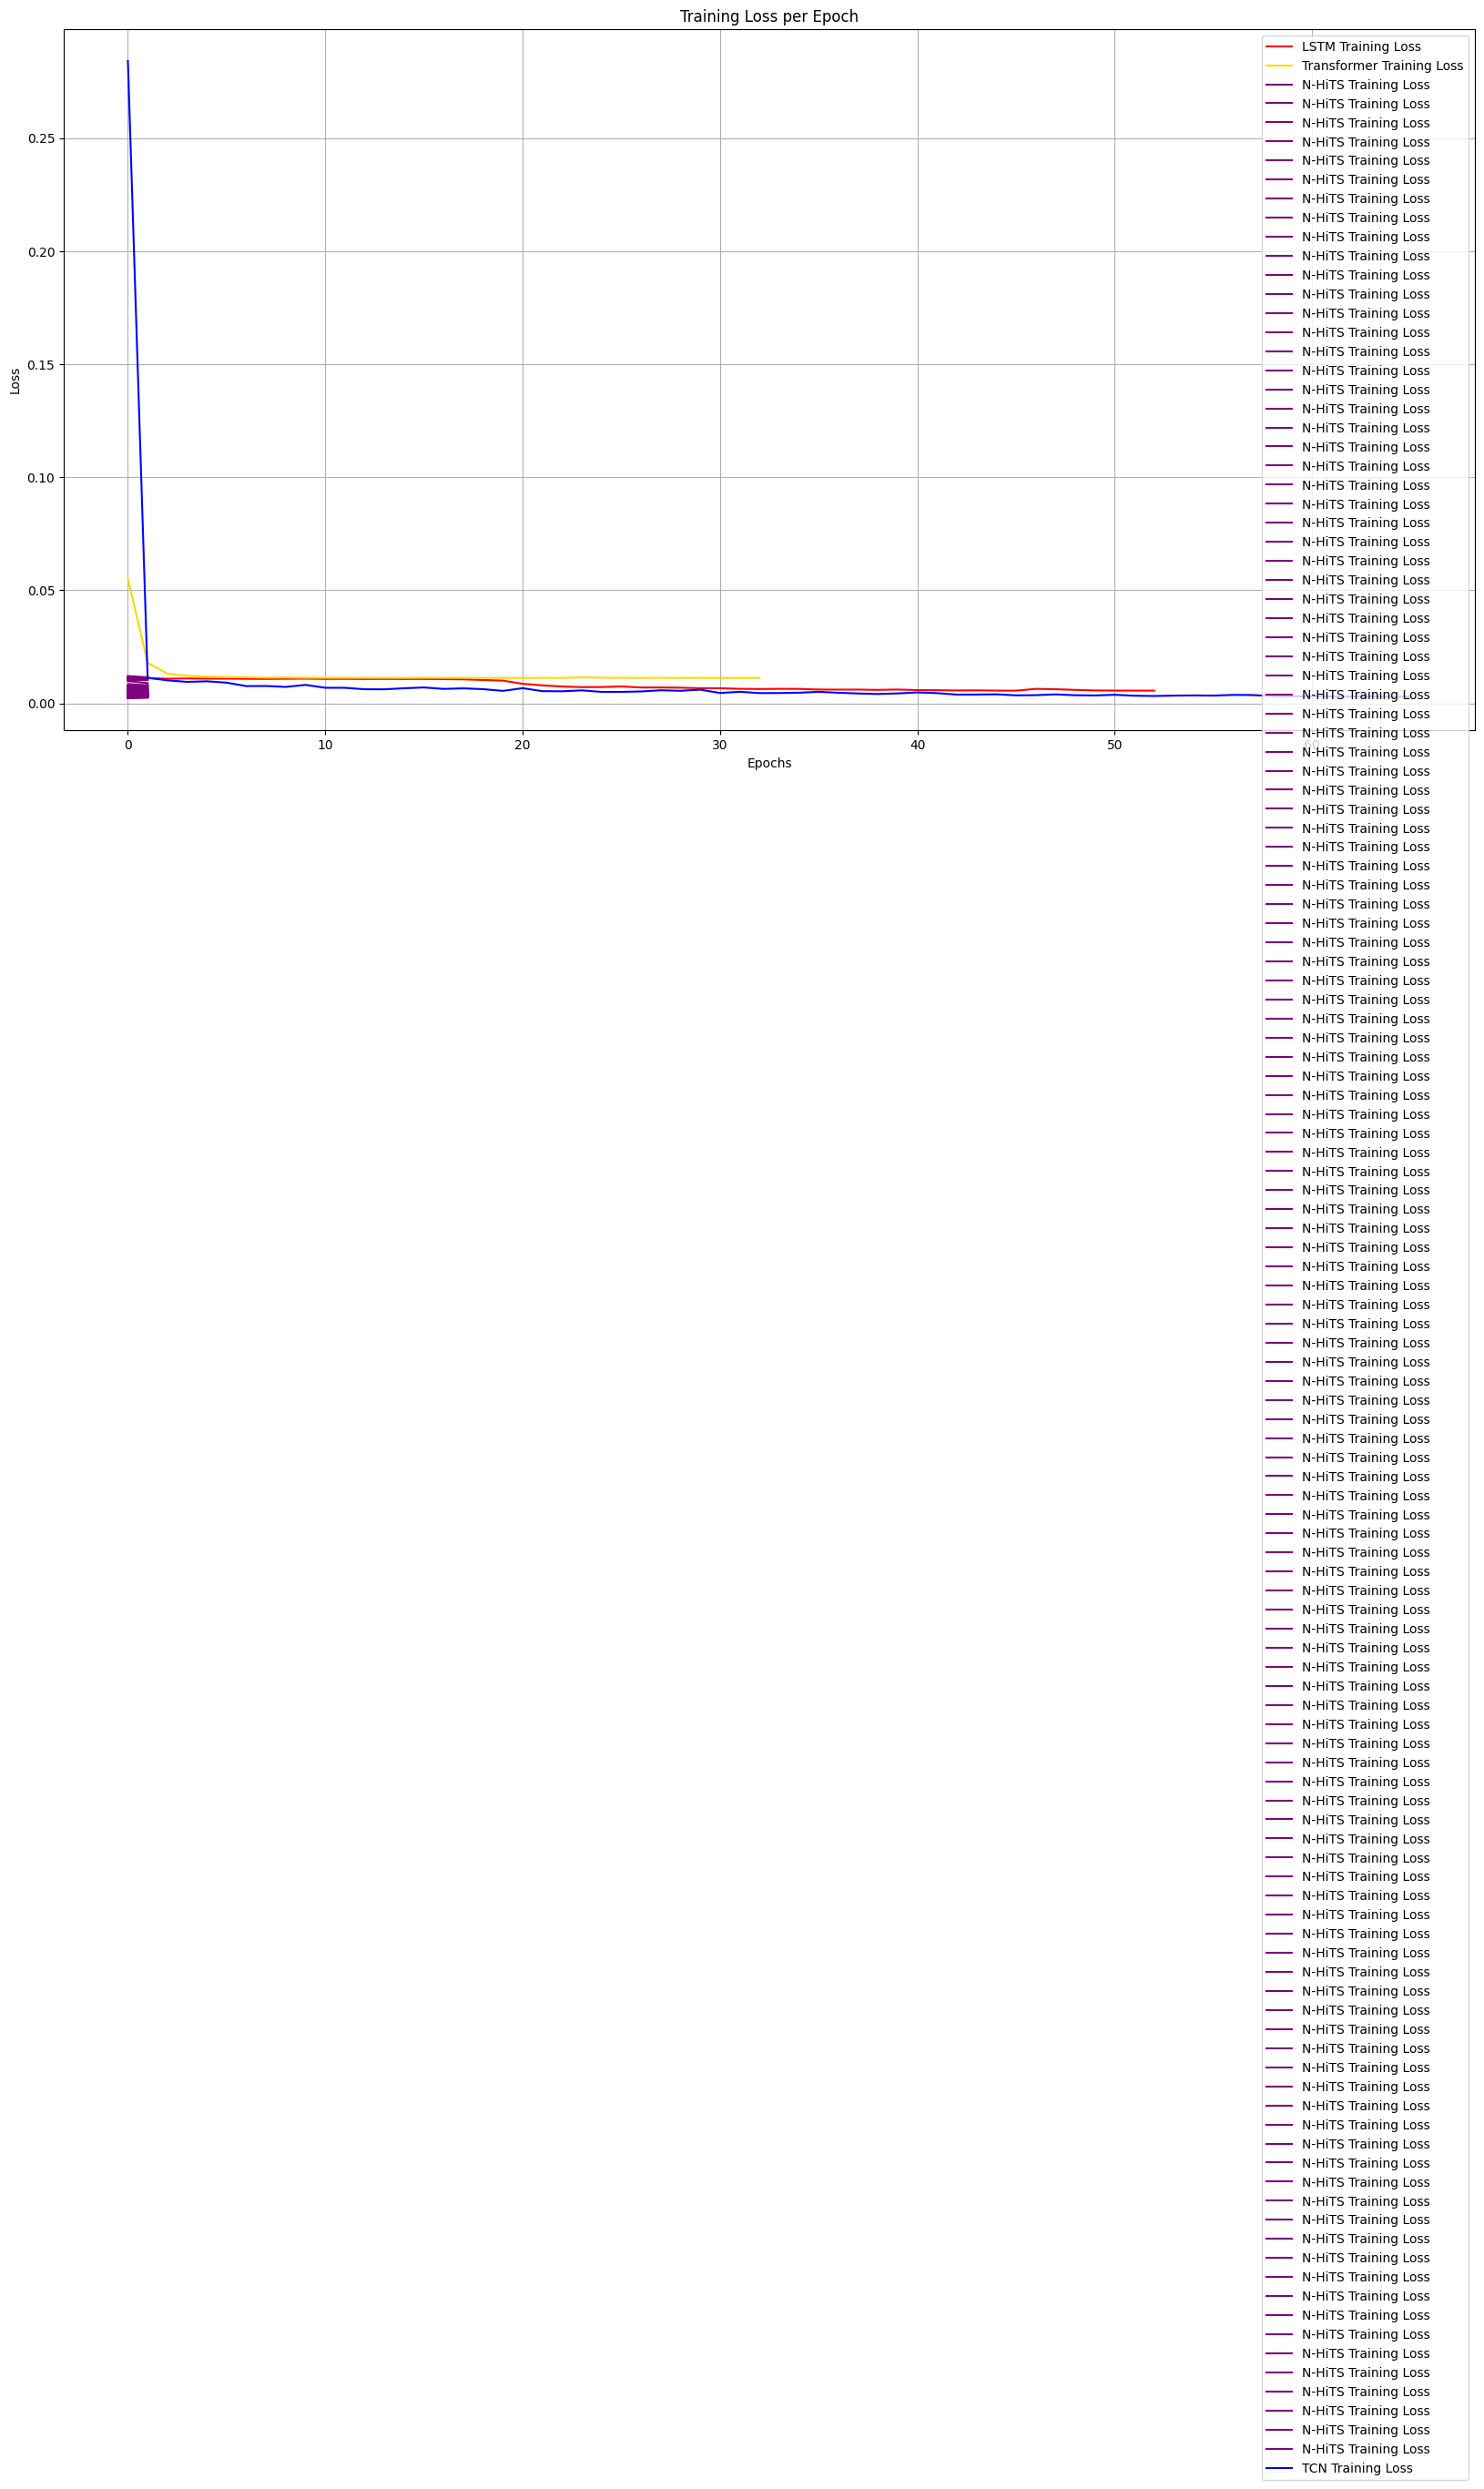

In [ ]:
# 학습 곡선 시각화
plt.figure(figsize=(20, 10))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss', color='red')
plt.plot(transformer_history.history['loss'], label='Transformer Training Loss', color='gold')
plt.plot(training_losses, label='N-HiTS Training Loss', color='purple')
plt.plot(tcn_history.history['loss'], label='TCN Training Loss', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

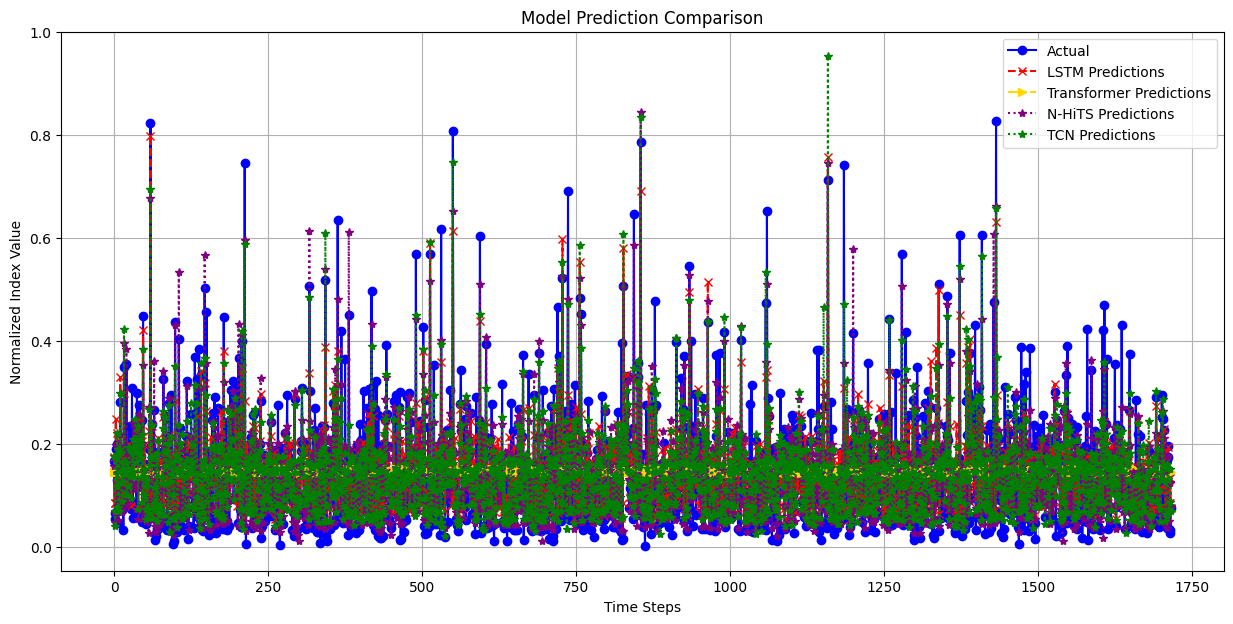

In [ ]:
# 모델 예측 결과 비교(통합그래프)
plt.figure(figsize=(15, 7))
plt.plot(y_test, label='Actual', color='blue', marker='o', linestyle='-')
plt.plot(test_predict_lstm, label='LSTM Predictions', color='red', marker='x', linestyle='--')
plt.plot(test_predict_transformer, label='Transformer Predictions', color='gold', marker='>', linestyle='-.')
plt.plot(test_predict_nhits, label='N-HiTS Predictions', color='purple', marker='*', linestyle=':')
plt.plot(test_predict_tcn, label='TCN Predictions', color='green', marker='*', linestyle=':')
plt.title('Model Prediction Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Index Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 평가지표 계산 및 출력
def calculate_metrics(model_name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mask = y_true != 0 # MAPE 계산을 위해 y_true가 0인 경우를 제외하고 계산
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    print(f"{model_name} RMSE: {rmse:.4f}")
    print(f"{model_name} MAE: {mae:.4f}")
    print(f"{model_name} R2: {r2:.4f}")
    print(f"{model_name} MAPE: {mape:.2f}%")


# 모델 성능 평가
calculate_metrics("LSTM", y_test, test_predict_lstm)
calculate_metrics("Transformer", y_test, test_predict_transformer)
calculate_metrics("N-HiTS", y_test, test_predict_nhits)
calculate_metrics("TCN", y_test, test_predict_tcn)

LSTM RMSE: 0.0717
LSTM MAE: 0.0515
LSTM R2: 0.5632
LSTM MAPE: 127.48%
Transformer RMSE: 0.1083
Transformer MAE: 0.0789
Transformer R2: 0.0020
Transformer MAPE: 119.34%
N-HiTS RMSE: 0.0544
N-HiTS MAE: 0.0388
N-HiTS R2: 0.7486
N-HiTS MAPE: 128.71%
TCN RMSE: 0.0591
TCN MAE: 0.0425
TCN R2: 0.7030
TCN MAPE: 131.27%


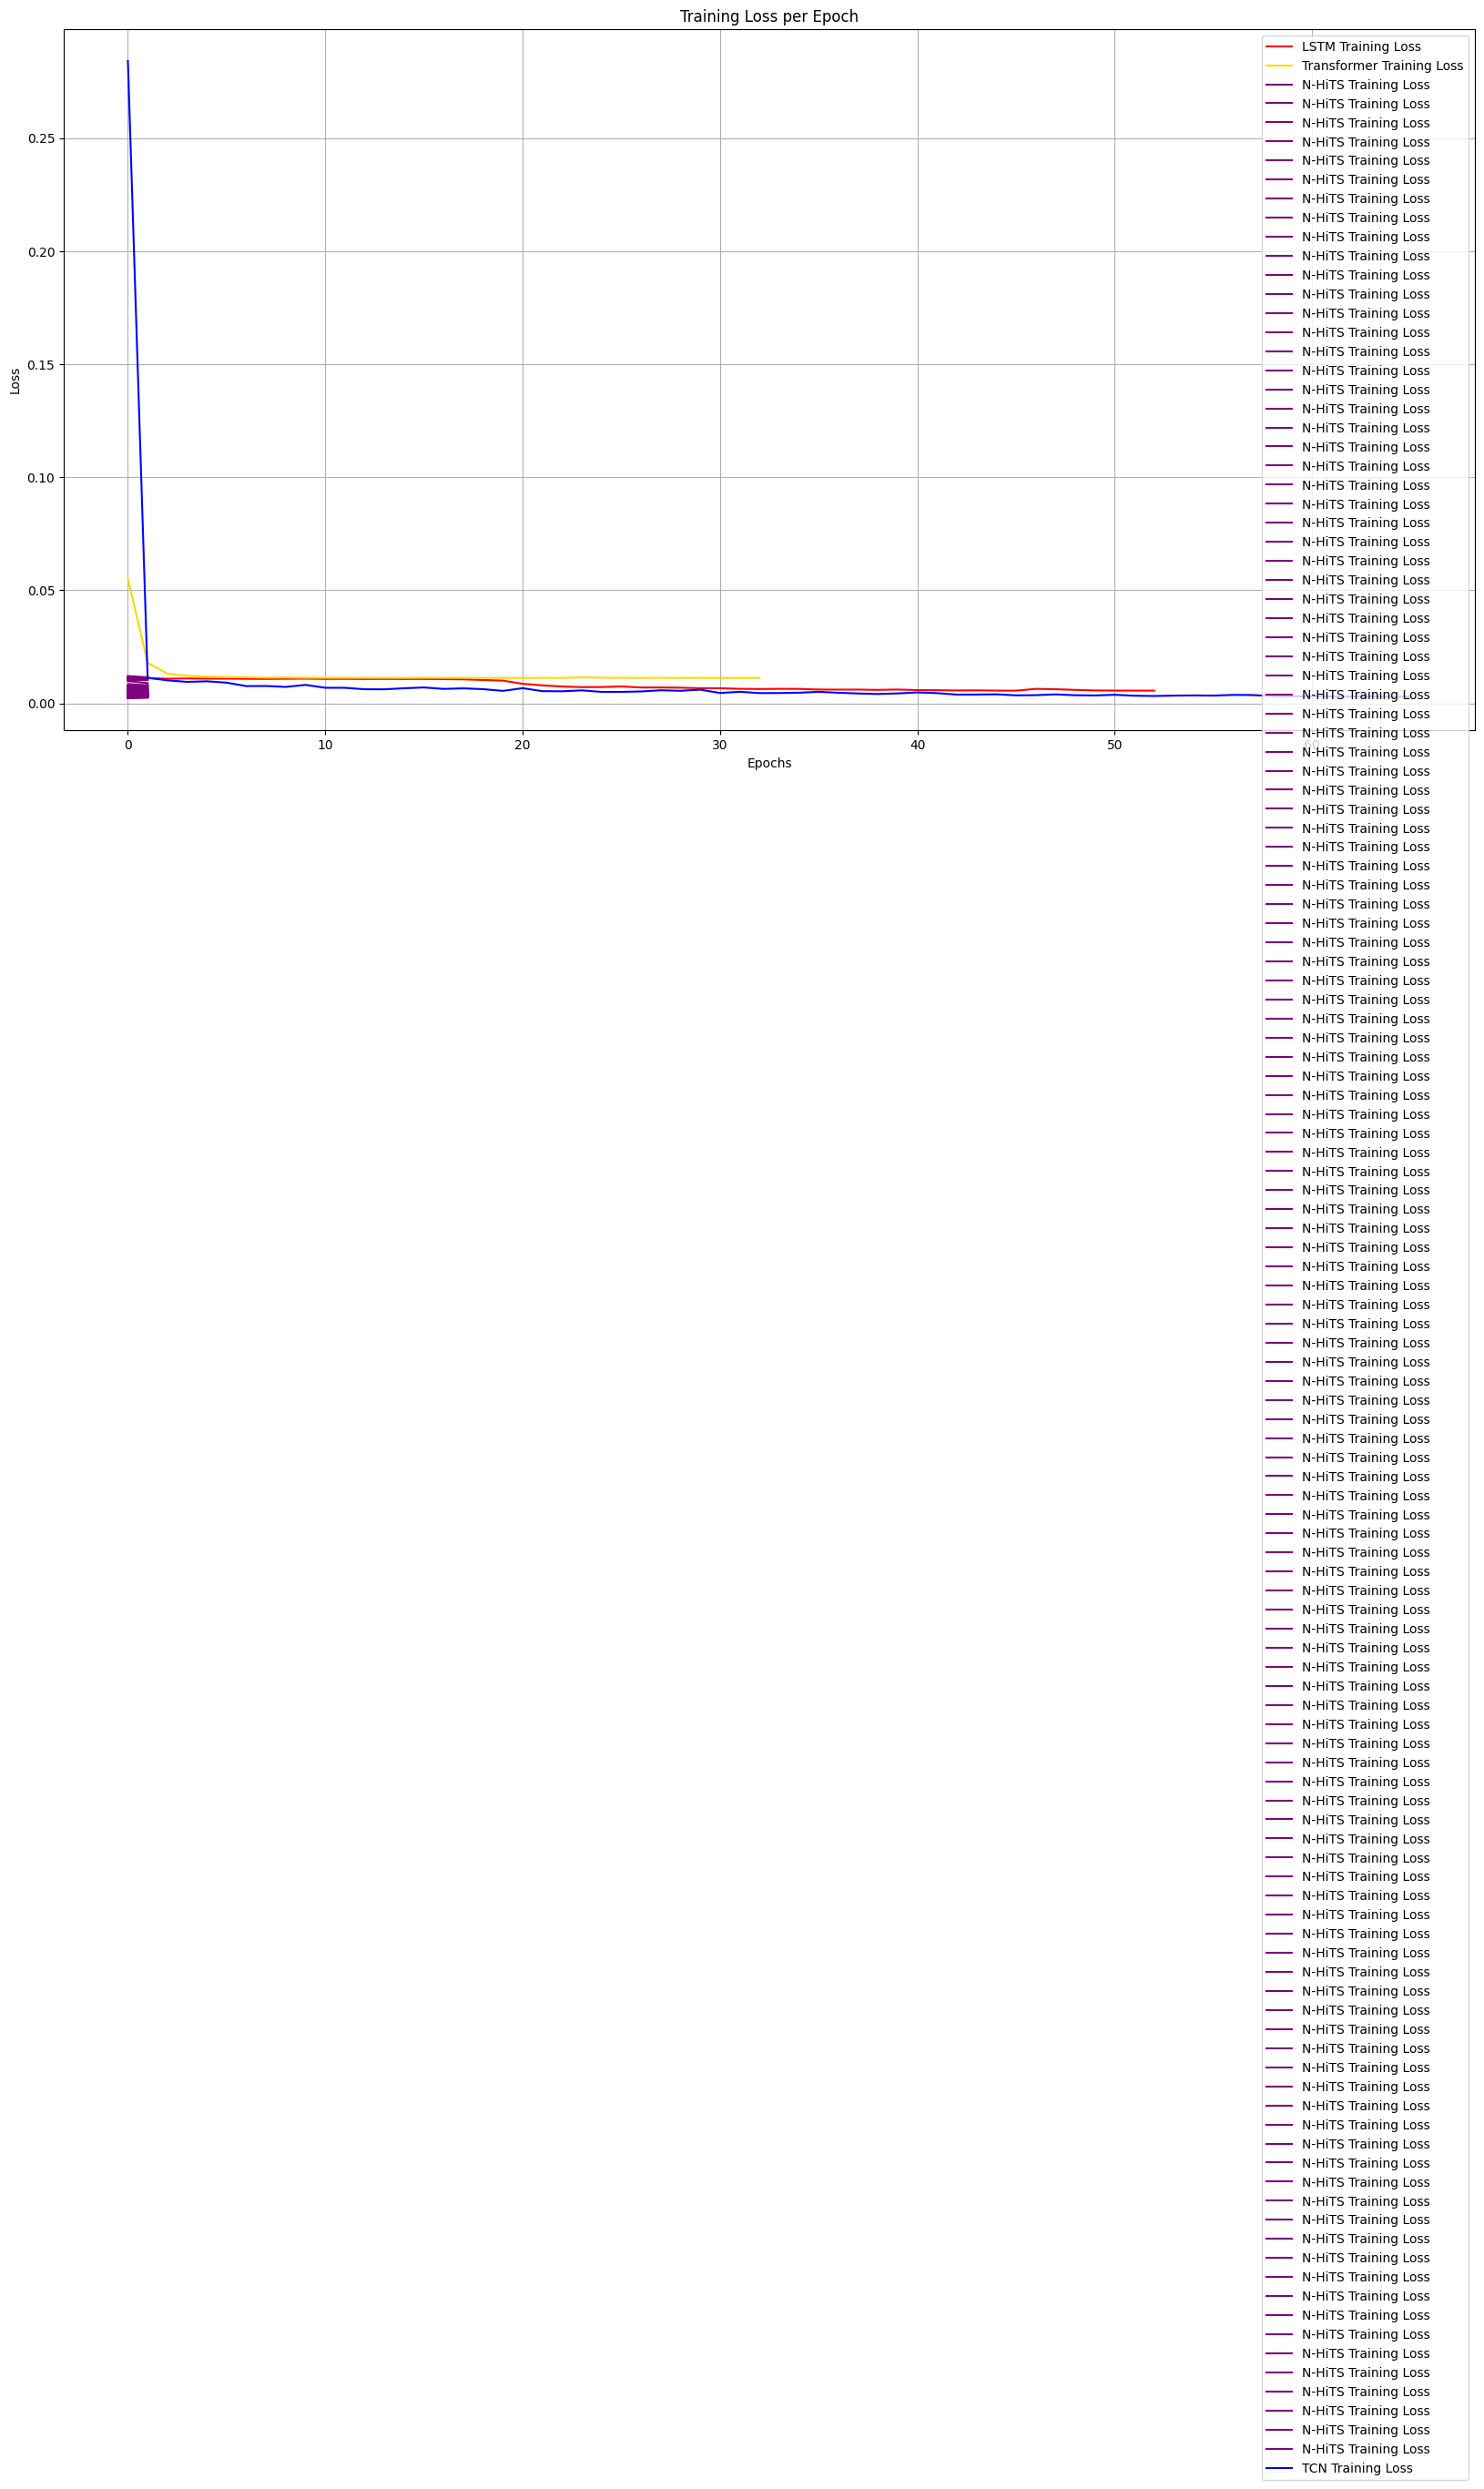

In [ ]:
# 학습 곡선 시각화
plt.figure(figsize=(20, 10))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss', color='red')
plt.plot(transformer_history.history['loss'], label='Transformer Training Loss', color='gold')
plt.plot(training_losses, label='N-HiTS Training Loss', color='purple')
plt.plot(tcn_history.history['loss'], label='TCN Training Loss', color='blue')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tcn import TCN, tcn_full_summary # TCN for Keras
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# N-HiTS model definition (assuming it is defined similarly to LSTM, TCN, Transformer)
class NHiTS(nn.Module):
    def __init__(self, input_size, num_layers, hidden_dim, num_outputs):
        super(NHiTS, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, num_outputs)

    def forward(self, input):
        lstm_out, _ = self.lstm(input)
        lstm_out = lstm_out[:, -1, :]  # only use the last output from sequence
        return self.linear(lstm_out)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mask = y_true != 0  # MAPE 계산을 위해 y_true가 0인 경우를 제외하고 계산
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return rmse, mae, r2, mape

# Function to create performance table
def create_performance_table(models_predictions, y_tests, indices):
    results = []
    for idx, index in enumerate(indices):
        for model_name, preds in models_predictions.items():
            rmse, mae, r2, mape = calculate_metrics(y_tests[index], preds[index])
            results.append([index, model_name, rmse, mae, r2, mape])
    return pd.DataFrame(results, columns=['Index', 'Model', 'RMSE', 'MAE', 'R2', 'MAPE'])

# Function to prepare dataset for a specific index
def prepare_dataset(data, time_step=1):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    X, y = create_dataset(data_scaled, time_step)
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset creation function (assuming the function is already defined)
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Assuming 'merged_data' is your combined dataset with 'S&P500', 'SKEW', 'VIX' columns
snp_data = merged_data[['S&P500']].values
skew_data = merged_data[['SKEW']].values
vix_data = merged_data[['VIX']].values

# Prepare datasets
time_step = 22
X_train_sp500, X_test_sp500, y_train_sp500, y_test_sp500 = prepare_dataset(snp_data, time_step)
X_train_skew, X_test_skew, y_train_skew, y_test_skew = prepare_dataset(skew_data, time_step)
X_train_vix, X_test_vix, y_train_vix, y_test_vix = prepare_dataset(vix_data, time_step)

# Reshape for LSTM and TCN models
X_train_sp500 = X_train_sp500.reshape((X_train_sp500.shape[0], X_train_sp500.shape[1], 1))
X_test_sp500 = X_test_sp500.reshape((X_test_sp500.shape[0], X_test_sp500.shape[1], 1))
X_train_skew = X_train_skew.reshape((X_train_skew.shape[0], X_train_skew.shape[1], 1))
X_test_skew = X_test_skew.reshape((X_test_skew.shape[0], X_test_skew.shape[1], 1))
X_train_vix = X_train_vix.reshape((X_train_vix.shape[0], X_train_vix.shape[1], 1))
X_test_vix = X_test_vix.reshape((X_test_vix.shape[0], X_test_vix.shape[1], 1))

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [ ]:
# Define and train the LSTM model on each dataset
def build_and_train_lstm(X_train, y_train, X_test):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    return model.predict(X_test), history

# Train and get predictions and history for each dataset
test_predict_lstm_sp500, history_lstm_sp500 = build_and_train_lstm(X_train_sp500, y_train_sp500, X_test_sp500)
test_predict_lstm_skew, history_lstm_skew = build_and_train_lstm(X_train_skew, y_train_skew, X_test_skew)
test_predict_lstm_vix, history_lstm_vix = build_and_train_lstm(X_train_vix, y_train_vix, X_test_vix)


Epoch 1/100
172/172 [==============================] - 12s 48ms/step - loss: 0.0046 - val_loss: 1.4187e-04
Epoch 2/100
172/172 [==============================] - 4s 25ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/100
172/172 [==============================] - 4s 26ms/step - loss: 9.8033e-04 - val_loss: 1.1212e-04
Epoch 4/100
172/172 [==============================] - 6s 36ms/step - loss: 8.5549e-04 - val_loss: 1.0032e-04
Epoch 5/100
172/172 [==============================] - 4s 25ms/step - loss: 7.6888e-04 - val_loss: 1.3672e-04
Epoch 6/100
172/172 [==============================] - 4s 25ms/step - loss: 7.1921e-04 - val_loss: 1.7519e-04
Epoch 7/100
172/172 [==============================] - 6s 34ms/step - loss: 7.2956e-04 - val_loss: 2.6501e-04
Epoch 8/100
172/172 [==============================] - 4s 25ms/step - loss: 7.3051e-04 - val_loss: 2.2305e-04
Epoch 9/100
172/172 [==============================] - 4s 25ms/step - loss: 6.6394e-04 - val_loss: 1.7336e-04
Epoch 10/100
172/172 

In [ ]:
# Define and train the TCN model on each dataset
def build_and_train_tcn(X_train, y_train, X_test):
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = TCN(nb_filters=64, kernel_size=6, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32], padding='causal',
            use_skip_connections=True, dropout_rate=0.0, return_sequences=False, activation='relu',
            kernel_initializer='he_normal', use_batch_norm=False)(input_layer)
    output_layer = Dense(1)(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    return model.predict(X_test), history

test_predict_tcn_sp500 = build_and_train_tcn(X_train_sp500, y_train_sp500, X_test_sp500)
test_predict_tcn_skew = build_and_train_tcn(X_train_skew, y_train_skew, X_test_skew)
test_predict_tcn_vix = build_and_train_tcn(X_train_vix, y_train_vix, X_test_vix)

Epoch 1/100
172/172 [==============================] - 19s 88ms/step - loss: 0.1178 - val_loss: 4.5301e-04
Epoch 2/100
172/172 [==============================] - 15s 85ms/step - loss: 3.3852e-04 - val_loss: 1.3544e-04
Epoch 3/100
172/172 [==============================] - 14s 82ms/step - loss: 2.3691e-04 - val_loss: 1.9053e-04
Epoch 4/100
172/172 [==============================] - 15s 88ms/step - loss: 1.9837e-04 - val_loss: 6.7884e-05
Epoch 5/100
172/172 [==============================] - 15s 86ms/step - loss: 9.4642e-05 - val_loss: 5.5315e-05
Epoch 6/100
172/172 [==============================] - 14s 84ms/step - loss: 9.1837e-05 - val_loss: 2.2893e-04
Epoch 7/100
172/172 [==============================] - 14s 81ms/step - loss: 3.1104e-04 - val_loss: 0.0014
Epoch 8/100
172/172 [==============================] - 14s 82ms/step - loss: 0.0017 - val_loss: 5.2528e-04
Epoch 9/100
172/172 [==============================] - 14s 83ms/step - loss: 1.7651e-04 - val_loss: 4.8832e-05
Epoch 10/100


In [ ]:
# Define EarlyStopping for PyTorch
class EarlyStoppingPyTorch:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [ ]:
# Define predict function for PyTorch model
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
    return np.array(predictions)

# Assuming N-HiTS model and other related functions and parameters are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

# EarlyStopping class for PyTorch (if not already defined)
class EarlyStoppingPyTorch:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss

# Train the N-HiTS model on each dataset
def build_and_train_nhits(X_train, y_train, X_test, y_test):
    n_hits_model = NHiTS(input_size=X_train.shape[2], num_layers=2, hidden_dim=50, num_outputs=1).to(device)
    optimizer = optim.Adam(n_hits_model.parameters(), lr=0.001)  # Use model parameters here
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)).view(-1, 1)), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)).view(-1, 1)), batch_size=32, shuffle=False)
    early_stopping = EarlyStoppingPyTorch(patience=10, verbose=True)

    training_losses = []
    validation_losses = []
    for epoch in range(300):
        n_hits_model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = n_hits_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        training_losses.append(train_loss)

        n_hits_model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = n_hits_model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_loss /= len(test_loader)
        validation_losses.append(val_loss)
        print(f'Epoch {epoch+1}/300, Training Loss: {train_loss}, Validation Loss: {val_loss}')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    predictions = predict(n_hits_model, test_loader)
    history = {'loss': training_losses, 'val_loss': validation_losses}
    return predictions, history

# Train the N-HiTS model and get the predictions and history for each dataset
test_predict_nhits_sp500, history_nhits_sp500 = build_and_train_nhits(X_train_sp500, y_train_sp500, X_test_sp500, y_test_sp500)
test_predict_nhits_skew, history_nhits_skew = build_and_train_nhits(X_train_skew, y_train_skew, X_test_skew, y_test_skew)
test_predict_nhits_vix, history_nhits_vix = build_and_train_nhits(X_train_vix, y_train_vix, X_test_vix, y_test_vix)

Epoch 1/300, Training Loss: 0.01244766814454843, Validation Loss: 0.00024233074361324758
Validation loss decreased (inf --> 0.000242).  Saving model ...
Epoch 2/300, Training Loss: 0.00019157793359163617, Validation Loss: 0.000134339633303979
Validation loss decreased (0.000242 --> 0.000134).  Saving model ...
Epoch 3/300, Training Loss: 0.00010420031826787488, Validation Loss: 8.873810205571956e-05
Validation loss decreased (0.000134 --> 0.000089).  Saving model ...
Epoch 4/300, Training Loss: 0.00011890532634932369, Validation Loss: 8.49867591804704e-05
Validation loss decreased (0.000089 --> 0.000085).  Saving model ...
Epoch 5/300, Training Loss: 0.00010784604091895744, Validation Loss: 8.852890965095462e-05
EarlyStopping counter: 1 out of 10
Epoch 6/300, Training Loss: 8.966015598690679e-05, Validation Loss: 8.315958644676289e-05
Validation loss decreased (0.000085 --> 0.000083).  Saving model ...
Epoch 7/300, Training Loss: 8.287748597615783e-05, Validation Loss: 7.86870693142797

Epoch 1/100
172/172 [==============================] - 12s 31ms/step - loss: 0.0046 - val_loss: 1.7030e-04
Epoch 2/100
172/172 [==============================] - 6s 33ms/step - loss: 0.0010 - val_loss: 9.6238e-05
Epoch 3/100
172/172 [==============================] - 4s 25ms/step - loss: 8.9173e-04 - val_loss: 1.1984e-04
Epoch 4/100
172/172 [==============================] - 5s 29ms/step - loss: 9.4506e-04 - val_loss: 1.5782e-04
Epoch 5/100
172/172 [==============================] - 6s 32ms/step - loss: 8.3918e-04 - val_loss: 1.0189e-04
Epoch 6/100
172/172 [==============================] - 4s 25ms/step - loss: 8.2344e-04 - val_loss: 1.2770e-04
Epoch 7/100
172/172 [==============================] - 5s 29ms/step - loss: 6.9631e-04 - val_loss: 9.2058e-05
Epoch 8/100
172/172 [==============================] - 5s 30ms/step - loss: 7.1551e-04 - val_loss: 1.1206e-04
Epoch 9/100
172/172 [==============================] - 4s 25ms/step - loss: 6.6369e-04 - val_loss: 2.1143e-04
Epoch 10/100
172/

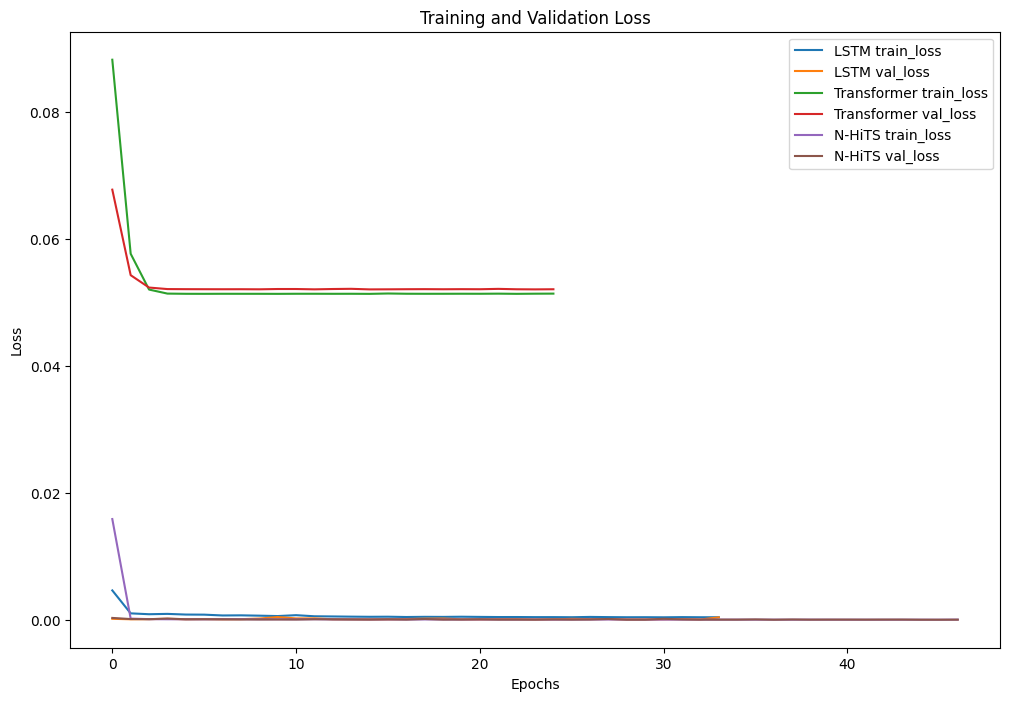

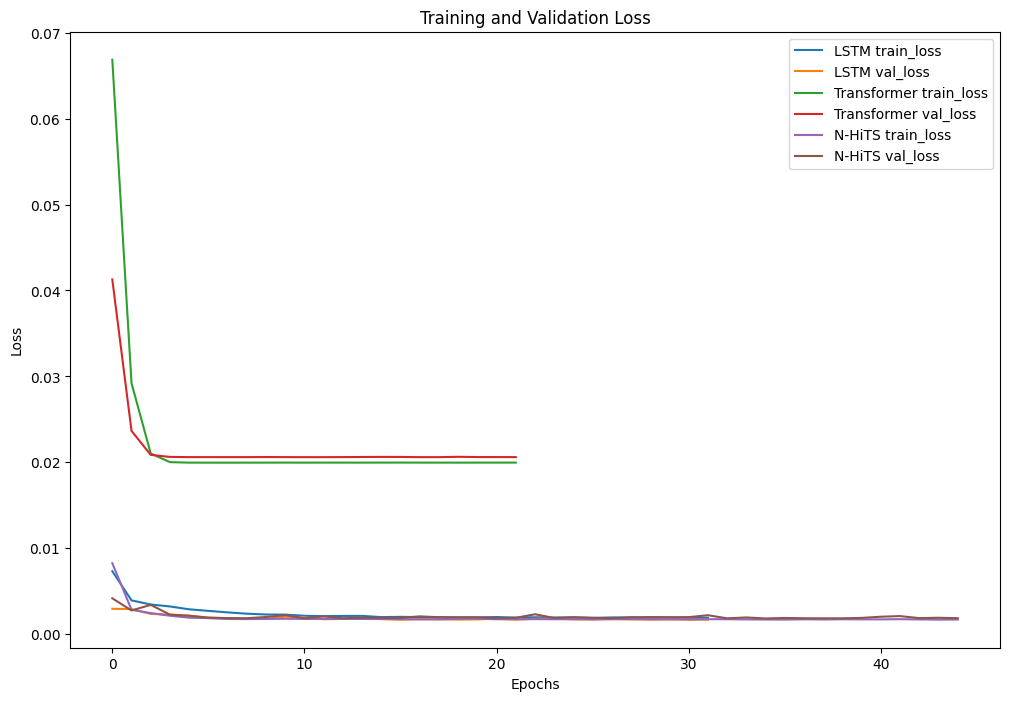

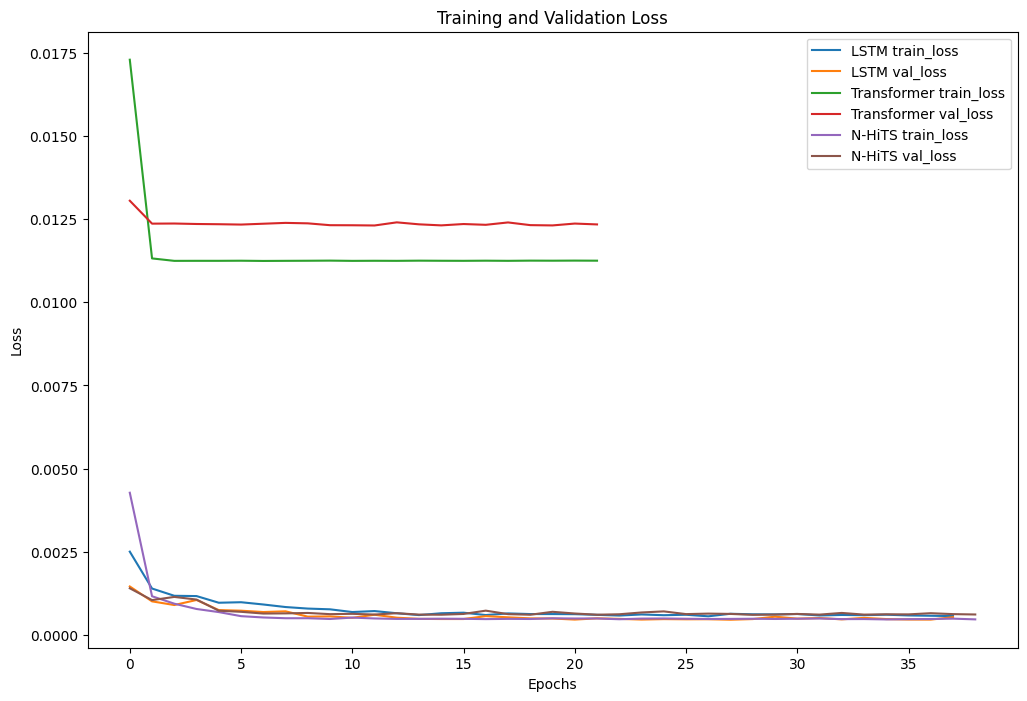

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define and train the LSTM model on each dataset
def build_and_train_lstm(X_train, y_train, X_test):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    return model.predict(X_test), history

# Define and train the Transformer model on each dataset
def build_and_train_transformer(X_train, y_train, X_test):
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=256, num_heads=4, dropout=0.25)(x, x)
    x = Dropout(0.25)(x)
    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.25)(x)
    outputs = Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    return model.predict(X_test), history

# Define predict function for PyTorch model
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
    return np.array(predictions)

# Assuming N-HiTS model and other related functions and parameters are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

# EarlyStopping class for PyTorch (if not already defined)
class EarlyStoppingPyTorch:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss

# Train the N-HiTS model on each dataset
def build_and_train_nhits(X_train, y_train, X_test, y_test):
    n_hits_model = NHiTS(input_size=X_train.shape[2], num_layers=2, hidden_dim=50, num_outputs=1).to(device)
    optimizer = optim.Adam(n_hits_model.parameters(), lr=0.001)  # Use model parameters here
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)).view(-1, 1)), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)).view(-1, 1)), batch_size=32, shuffle=False)
    early_stopping = EarlyStoppingPyTorch(patience=10, verbose=True)

    training_losses = []
    validation_losses = []
    for epoch in range(300):
        n_hits_model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = n_hits_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        training_losses.append(train_loss)

        n_hits_model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = n_hits_model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_loss /= len(test_loader)
        validation_losses.append(val_loss)
        print(f'Epoch {epoch+1}/300, Training Loss: {train_loss}, Validation Loss: {val_loss}')

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    predictions = predict(n_hits_model, test_loader)
    history = {'loss': training_losses, 'val_loss': validation_losses}
    return predictions, history

# Train the models and get the predictions and history for each dataset
test_predict_lstm_sp500, history_lstm_sp500 = build_and_train_lstm(X_train_sp500, y_train_sp500, X_test_sp500)
test_predict_lstm_skew, history_lstm_skew = build_and_train_lstm(X_train_skew, y_train_skew, X_test_skew)
test_predict_lstm_vix, history_lstm_vix = build_and_train_lstm(X_train_vix, y_train_vix, X_test_vix)

test_predict_transformer_sp500, history_transformer_sp500 = build_and_train_transformer(X_train_sp500, y_train_sp500, X_test_sp500)
test_predict_transformer_skew, history_transformer_skew = build_and_train_transformer(X_train_skew, y_train_skew, X_test_skew)
test_predict_transformer_vix, history_transformer_vix = build_and_train_transformer(X_train_vix, y_train_vix, X_test_vix)

test_predict_nhits_sp500, history_nhits_sp500 = build_and_train_nhits(X_train_sp500, y_train_sp500, X_test_sp500, y_test_sp500)
test_predict_nhits_skew, history_nhits_skew = build_and_train_nhits(X_train_skew, y_train_skew, X_test_skew, y_test_skew)
test_predict_nhits_vix, history_nhits_vix = build_and_train_nhits(X_train_vix, y_train_vix, X_test_vix, y_test_vix)

# Plot training history for all models
def plot_all_histories(histories, model_names):
    plt.figure(figsize=(12, 8))
    for history, model_name in zip(histories, model_names):
        plt.plot(history['loss'], label=f'{model_name} train_loss')
        plt.plot(history['val_loss'], label=f'{model_name} val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Collect all histories and model names
histories_sp500 = [history_lstm_sp500.history, history_transformer_sp500.history, history_nhits_sp500]  # Add history_tcn_sp500 when available
histories_skew = [history_lstm_skew.history, history_transformer_skew.history, history_nhits_skew]  # Add history_tcn_skew when available
histories_vix = [history_lstm_vix.history, history_transformer_vix.history, history_nhits_vix]  # Add history_tcn_vix when available

model_names = ['LSTM', 'Transformer', 'N-HiTS']  # Add 'TCN' when available

# Plot all learning curves for each dataset
plot_all_histories(histories_sp500, model_names)
plot_all_histories(histories_skew, model_names)
plot_all_histories(histories_vix, model_names)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Function to create the performance table
def create_performance_table(models_predictions, y_tests, indices):
    rows = []
    for model_name, predictions in models_predictions.items():
        for index in indices:
            y_true = np.array(y_tests[index])
            y_pred = predictions[index]

            # Ensure consistent length by trimming
            if isinstance(y_pred[0], (list, np.ndarray)):
                y_pred = np.concatenate([np.array(p).flatten() for p in y_pred])
            else:
                y_pred = np.array(y_pred).flatten()

            min_length = min(len(y_true), len(y_pred))
            y_true = y_true[:min_length]
            y_pred = y_pred[:min_length]

            mse = mean_squared_error(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)

            rows.append({
                'Model': model_name,
                'Index': index,
                'MSE': mse,
                'MAE': mae,
                'R^2': r2
            })

    performance_table = pd.DataFrame(rows)
    return performance_table

# Actual test data for each index
y_tests = {
    'S&P500': y_test_sp500,
    'SKEW': y_test_skew,
    'VIX': y_test_vix
}

# Organize predictions
models_predictions = {
    'LSTM': {
        'S&P500': test_predict_lstm_sp500,
        'SKEW': test_predict_lstm_skew,
        'VIX': test_predict_lstm_vix
    },
    'Transformer': {
        'S&P500': test_predict_transformer_sp500,
        'SKEW': test_predict_transformer_skew,
        'VIX': test_predict_transformer_vix
    },
    'N-HiTS': {
        'S&P500': test_predict_nhits_sp500,
        'SKEW': test_predict_nhits_skew,
        'VIX': test_predict_nhits_vix
    },
    'TCN': {
        'S&P500': test_predict_tcn_sp500,
        'SKEW': test_predict_tcn_skew,
        'VIX': test_predict_tcn_vix
    }
}

# List of indices
indices = ['S&P500', 'SKEW', 'VIX']

# Create the performance table
performance_table = create_performance_table(models_predictions, y_tests, indices)

# Print the performance table
print(performance_table)

# Optionally, save the table to a CSV file
performance_table.to_csv('performance_table.csv', index=False)


          Model   Index       MSE       MAE       R^2
0          LSTM  S&P500  0.000057  0.004583  0.998878
1          LSTM    SKEW  0.001843  0.028058  0.907458
2          LSTM     VIX  0.000635  0.014037  0.946978
3   Transformer  S&P500  0.050751  0.177324 -0.001244
4   Transformer    SKEW  0.019928  0.109167 -0.000637
5   Transformer     VIX  0.011972  0.078497 -0.000020
6        N-HiTS  S&P500  0.000034  0.004192  0.999326
7        N-HiTS    SKEW  0.001865  0.028235  0.906364
8        N-HiTS     VIX  0.000616  0.014532  0.948542
9           TCN  S&P500  0.000027  0.003023  0.999460
10          TCN    SKEW  0.002030  0.029843  0.898060
11          TCN     VIX  0.000706  0.015256  0.941029


In [ ]:
def plot_all_histories(histories, model_names):
    plt.figure(figsize=(12, 8))
    for history, model_name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{model_name} train_loss')
        plt.plot(history.history['val_loss'], label=f'{model_name} val_loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Collect all histories and model names
histories = [history_lstm_sp500, history_transformer_sp500, history_tcn_sp500, history_nhits_sp500]
model_names = ['LSTM', 'Transformer', 'TCN', 'N-HiTS']

# Plot all learning curves
plot_all_histories(histories, model_names)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 예시 데이터
data = {
    'Index': ['S&P500', 'S&P500', 'S&P500', 'S&P500', 'DJIA', 'DJIA', 'DJIA', 'DJIA', 'Nasdaq', 'Nasdaq', 'Nasdaq', 'Nasdaq'],
    'Model': ['LSTM', 'Transformer', 'TCN', 'N-HiTS', 'LSTM', 'Transformer', 'TCN', 'N-HiTS', 'LSTM', 'Transformer', 'TCN', 'N-HiTS'],
    'RMSE': [0.25, 0.24, 0.22, 0.21, 0.28, 0.26, 0.23, 0.22, 0.27, 0.25, 0.24, 0.22],
    'MAE': [0.20, 0.19, 0.18, 0.17, 0.22, 0.21, 0.19, 0.18, 0.21, 0.20, 0.19, 0.18],
    'R2': [0.85, 0.86, 0.88, 0.89, 0.82, 0.84, 0.87, 0.88, 0.83, 0.85, 0.86, 0.87],
    'MAPE': [5, 4.8, 4.5, 4.3, 5.5, 5.2, 4.9, 4.7, 5.4, 5.1, 4.8, 4.6]
}

# DataFrame 생성
performance_table = pd.DataFrame(data)

# 플롯 설정
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# RMSE 플롯
axes[0, 0].set_title('RMSE')
for index in performance_table['Index'].unique():
    subset = performance_table[performance_table['Index'] == index]
    axes[0, 0].plot(subset['Model'], subset['RMSE'], marker='o', label=index)
axes[0, 0].legend()
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('RMSE')

# MAE 플롯
axes[0, 1].set_title('MAE')
for index in performance_table['Index'].unique():
    subset = performance_table[performance_table['Index'] == index]
    axes[0, 1].plot(subset['Model'], subset['MAE'], marker='o', label=index)
axes[0, 1].legend()
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('MAE')

# R2 플롯
axes[1, 0].set_title('R2')
for index in performance_table['Index'].unique():
    subset = performance_table[performance_table['Index'] == index]
    axes[1, 0].plot(subset['Model'], subset['R2'], marker='o', label=index)
axes[1, 0].legend()
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('R2')

# MAPE 플롯
axes[1, 1].set_title('MAPE')
for index in performance_table['Index'].unique():
    subset = performance_table[performance_table['Index'] == index]
    axes[1, 1].plot(subset['Model'], subset['MAPE'], marker='o', label=index)
axes[1, 1].legend()
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('MAPE')

# 플롯 표시
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터
data = {
    'Index': ['S&P500', 'S&P500', 'S&P500', 'S&P500', 'SKEW', 'SKEW', 'SKEW', 'SKEW', 'VIX', 'VIX', 'VIX', 'VIX'],
    'Model': ['LSTM', 'Transformer', 'N-HiTS', 'TCN', 'LSTM', 'Transformer', 'N-HiTS', 'TCN', 'LSTM', 'Transformer', 'N-HiTS', 'TCN'],
    'RMSE': [0.006000, 0.229609, 0.004695, 0.005064, 0.044248, 0.143572, 0.044747, 0.044474, 0.019910, 0.103083, 0.020289, 0.020967],
    'MAE': [0.003795, 0.178977, 0.003122, 0.003175, 0.029066, 0.110051, 0.029289, 0.029238, 0.013499, 0.076686, 0.013236, 0.014776],
    'R2': [0.999317, -0.000015, 0.999582, 0.999514, 0.904949, -0.000708, 0.902792, 0.903974, 0.962604, -0.002417, 0.961168, 0.958530],
    'MAPE': [396.774051, 367.914603, 398.472051, 397.157476, 60.276521, 45.351384, 59.140701, 59.730743, 197.871169, 180.365116, 190.141242, 203.049523]
}

# DataFrame 생성
performance_table = pd.DataFrame(data)

# RMSE 플롯
plt.figure(figsize=(7, 5))
plt.title('RMSE')
for index in performance_table['Index'].unique():
    subset = performance_table[performance_table['Index'] == index]
    plt.plot(subset['Model'], subset['RMSE'], marker='o', label=index)
plt.legend()
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

# MAE 플롯
plt.figure(figsize=(7, 5))
plt.title('MAE')
for index in performance_table['Index'].unique():
    subset = performance_table[performance_table['Index'] == index]
    plt.plot(subset['Model'], subset['MAE'], marker='o', label=index)
plt.legend()
plt.xlabel('Model')
plt.ylabel('MAE')
plt.show()

# R2 플롯
plt.figure(figsize=(7, 5))
plt.title('R2')
for index in performance_table['Index'].unique():
    subset = performance_table[performance_table['Index'] == index]
    plt.plot(subset['Model'], subset['R2'], marker='o', label=index)
plt.legend()
plt.xlabel('Model')
plt.ylabel('R2')
plt.show()

# MAPE 플롯
plt.figure(figsize=(7, 5))
plt.title('MAPE')
for index in performance_table['Index'].unique():
    subset = performance_table[performance_table['Index'] == index]
    plt.plot(subset['Model'], subset['MAPE'], marker='o', label=index)
plt.legend()
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.show()

In [ ]:
# LSTM 모델 예측 데이터 생성 및 시각화
plt.figure(figsize=(12, 6))

# 실제 데이터
plt.plot(y_test_sp500, label='Actual S&P500')
# LSTM 예측 데이터
plt.plot(test_predict_lstm_sp500, label='LSTM Prediction')

plt.title('LSTM Model Prediction vs Actual Data for S&P500')
plt.xlabel('Time')
plt.ylabel('S&P500 Index')
plt.legend()
plt.show()

In [ ]:
# Transformer 모델 예측 데이터 생성 및 시각화
plt.figure(figsize=(12, 6))

# 실제 데이터
plt.plot(y_test_sp500, label='Actual S&P500')
# Transformer 예측 데이터
plt.plot(test_predict_transformer_sp500, label='Transformer Prediction')

plt.title('Transformer Model Prediction vs Actual Data for S&P500')
plt.xlabel('Time')
plt.ylabel('S&P500 Index')
plt.legend()
plt.show()


In [ ]:
# N-HiTS 모델 예측 데이터 생성 및 시각화
plt.figure(figsize=(12, 6))

# 실제 데이터
plt.plot(y_test_sp500, label='Actual S&P500')
# N-HiTS 예측 데이터
plt.plot(test_predict_nhits_sp500, label='N-HiTS Prediction')

plt.title('N-HiTS Model Prediction vs Actual Data for S&P500')
plt.xlabel('Time')
plt.ylabel('S&P500 Index')
plt.legend()
plt.show()


In [ ]:
# TCN 모델 예측 데이터 생성 및 시각화
plt.figure(figsize=(12, 6))

# 실제 데이터
plt.plot(y_test_sp500, label='Actual S&P500')
# TCN 예측 데이터
plt.plot(test_predict_tcn_sp500, label='TCN Prediction')

plt.title('TCN Model Prediction vs Actual Data for S&P500')
plt.xlabel('Time')
plt.ylabel('S&P500 Index')
plt.legend()
plt.show()


In [ ]:
# SKEW 지표 예측 데이터 생성 및 시각화
plt.figure(figsize=(12, 6))

# 실제 데이터
plt.plot(y_test_skew, label='Actual SKEW')
# LSTM 예측 데이터
plt.plot(test_predict_lstm_skew, label='LSTM Prediction')
# Transformer 예측 데이터
plt.plot(test_predict_transformer_skew, label='Transformer Prediction')
# N-HiTS 예측 데이터
plt.plot(test_predict_nhits_skew, label='N-HiTS Prediction')
# TCN 예측 데이터
plt.plot(test_predict_tcn_skew, label='TCN Prediction')

plt.title('Model Predictions vs Actual Data for SKEW')
plt.xlabel('Time')
plt.ylabel('SKEW Index')
plt.legend()
plt.show()


In [ ]:
# VIX 지표 예측 데이터 생성 및 시각화
plt.figure(figsize=(12, 6))

# 실제 데이터
plt.plot(y_test_vix, label='Actual VIX')
# LSTM 예측 데이터
plt.plot(test_predict_lstm_vix, label='LSTM Prediction')
# Transformer 예측 데이터
plt.plot(test_predict_transformer_vix, label='Transformer Prediction')
# N-HiTS 예측 데이터
plt.plot(test_predict_nhits_vix, label='N-HiTS Prediction')
# TCN 예측 데이터
plt.plot(test_predict_tcn_vix, label='TCN Prediction')

plt.title('Model Predictions vs Actual Data for VIX')
plt.xlabel('Time')
plt.ylabel('VIX Index')
plt.legend()
plt.show()
